In [1]:
import gym
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('BipedalWalker-v2')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.00008 # lr = 0.0001 for BipedalWalker-SAC_lr0001
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)

max_steps:  1600
device:  cuda:0
state dim:  24
action dim:  Box(4,)
leraning rate:  8e-05


In [2]:
def save(agent, directory, filename, suffix):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 10001
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if i_episode % 20 == 0 and i_episode > 0:
            save(agent, 'dir_chk_lr00008', 'weights', str(i_episode))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > 300.5):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train(max_steps=max_steps)

Ep.: 0, Total Steps: 77, Ep.Steps: 77, Score: -114.65, Avg.Score: -114.65, Time: 00:00:00
Ep.: 1, Total Steps: 1677, Ep.Steps: 1600, Score: -78.28, Avg.Score: -96.46, Time: 00:01:32
Ep.: 2, Total Steps: 1741, Ep.Steps: 64, Score: -111.78, Avg.Score: -101.57, Time: 00:01:36
Ep.: 3, Total Steps: 3341, Ep.Steps: 1600, Score: -86.86, Avg.Score: -97.89, Time: 00:03:11
Ep.: 4, Total Steps: 3388, Ep.Steps: 47, Score: -109.59, Avg.Score: -100.23, Time: 00:03:13
Ep.: 5, Total Steps: 4988, Ep.Steps: 1600, Score: -88.05, Avg.Score: -98.20, Time: 00:04:47
Ep.: 6, Total Steps: 6588, Ep.Steps: 1600, Score: -80.07, Avg.Score: -95.61, Time: 00:06:23
Ep.: 7, Total Steps: 8188, Ep.Steps: 1600, Score: -91.96, Avg.Score: -95.15, Time: 00:08:02
Ep.: 8, Total Steps: 8260, Ep.Steps: 72, Score: -106.64, Avg.Score: -96.43, Time: 00:08:07
Ep.: 9, Total Steps: 8383, Ep.Steps: 123, Score: -98.78, Avg.Score: -96.67, Time: 00:08:15
Ep.: 10, Total Steps: 9983, Ep.Steps: 1600, Score: -86.57, Avg.Score: -95.75, Time: 

Ep.: 88, Total Steps: 73330, Ep.Steps: 96, Score: -130.62, Avg.Score: -97.83, Time: 01:15:32
Ep.: 89, Total Steps: 73422, Ep.Steps: 92, Score: -131.31, Avg.Score: -98.20, Time: 01:15:38
Ep.: 90, Total Steps: 73502, Ep.Steps: 80, Score: -120.89, Avg.Score: -98.45, Time: 01:15:42
Ep.: 91, Total Steps: 73599, Ep.Steps: 97, Score: -131.24, Avg.Score: -98.80, Time: 01:15:48
Ep.: 92, Total Steps: 73677, Ep.Steps: 78, Score: -129.27, Avg.Score: -99.13, Time: 01:15:53
Ep.: 93, Total Steps: 73767, Ep.Steps: 90, Score: -133.08, Avg.Score: -99.49, Time: 01:15:58
Ep.: 94, Total Steps: 73844, Ep.Steps: 77, Score: -125.95, Avg.Score: -99.77, Time: 01:16:03
Ep.: 95, Total Steps: 73924, Ep.Steps: 80, Score: -126.26, Avg.Score: -100.05, Time: 01:16:08
Ep.: 96, Total Steps: 74159, Ep.Steps: 235, Score: -140.07, Avg.Score: -100.46, Time: 01:16:22
Ep.: 97, Total Steps: 74238, Ep.Steps: 79, Score: -129.29, Avg.Score: -100.75, Time: 01:16:27
Ep.: 98, Total Steps: 74325, Ep.Steps: 87, Score: -129.05, Avg.Sco

Ep.: 175, Total Steps: 177891, Ep.Steps: 1600, Score: -59.22, Avg.Score: -59.11, Time: 03:00:49
Ep.: 176, Total Steps: 179491, Ep.Steps: 1600, Score: -47.77, Avg.Score: -58.45, Time: 03:02:25
Ep.: 177, Total Steps: 179954, Ep.Steps: 463, Score: -102.71, Avg.Score: -58.33, Time: 03:02:53
Ep.: 178, Total Steps: 181554, Ep.Steps: 1600, Score: -16.08, Avg.Score: -57.46, Time: 03:04:34
Ep.: 179, Total Steps: 182021, Ep.Steps: 467, Score: -103.20, Avg.Score: -57.55, Time: 03:05:02
Ep.: 180, Total Steps: 182538, Ep.Steps: 517, Score: -57.25, Avg.Score: -57.42, Time: 03:05:33
Ep.: 181, Total Steps: 182929, Ep.Steps: 391, Score: -90.93, Avg.Score: -57.71, Time: 03:05:57
Ep.: 182, Total Steps: 184529, Ep.Steps: 1600, Score: 84.07, Avg.Score: -55.68, Time: 03:07:33
Ep.: 183, Total Steps: 186129, Ep.Steps: 1600, Score: 179.26, Avg.Score: -52.70, Time: 03:09:10
Ep.: 184, Total Steps: 187729, Ep.Steps: 1600, Score: 162.03, Avg.Score: -49.88, Time: 03:10:46
Ep.: 185, Total Steps: 189321, Ep.Steps: 15

Ep.: 261, Total Steps: 294778, Ep.Steps: 1160, Score: 292.08, Avg.Score: 172.04, Time: 05:01:30
Ep.: 262, Total Steps: 295946, Ep.Steps: 1168, Score: 290.61, Avg.Score: 176.00, Time: 05:02:38
Ep.: 263, Total Steps: 297105, Ep.Steps: 1159, Score: 291.76, Avg.Score: 179.71, Time: 05:03:47
Ep.: 264, Total Steps: 298300, Ep.Steps: 1195, Score: 291.77, Avg.Score: 182.65, Time: 05:04:57
Ep.: 265, Total Steps: 299507, Ep.Steps: 1207, Score: 289.90, Avg.Score: 186.56, Time: 05:06:09
Ep.: 266, Total Steps: 300783, Ep.Steps: 1276, Score: 284.74, Avg.Score: 190.30, Time: 05:07:24
Ep.: 267, Total Steps: 301955, Ep.Steps: 1172, Score: 292.28, Avg.Score: 193.32, Time: 05:08:33
Ep.: 268, Total Steps: 303117, Ep.Steps: 1162, Score: 289.38, Avg.Score: 196.71, Time: 05:09:42
Ep.: 269, Total Steps: 304307, Ep.Steps: 1190, Score: 291.95, Avg.Score: 199.70, Time: 05:10:52
Ep.: 270, Total Steps: 305443, Ep.Steps: 1136, Score: 293.81, Avg.Score: 202.92, Time: 05:12:00
Ep.: 271, Total Steps: 306633, Ep.Steps:

Ep.: 347, Total Steps: 386092, Ep.Steps: 991, Score: 300.15, Avg.Score: 287.19, Time: 06:31:33
Ep.: 348, Total Steps: 387054, Ep.Steps: 962, Score: 302.13, Avg.Score: 287.40, Time: 06:32:46
Ep.: 349, Total Steps: 388016, Ep.Steps: 962, Score: 299.23, Avg.Score: 287.59, Time: 06:33:46
Ep.: 350, Total Steps: 389016, Ep.Steps: 1000, Score: 296.63, Avg.Score: 287.76, Time: 06:34:47
Ep.: 351, Total Steps: 390025, Ep.Steps: 1009, Score: 299.28, Avg.Score: 287.94, Time: 06:35:58
Ep.: 352, Total Steps: 390963, Ep.Steps: 938, Score: 303.66, Avg.Score: 288.11, Time: 06:37:11
Ep.: 353, Total Steps: 391914, Ep.Steps: 951, Score: 301.67, Avg.Score: 288.23, Time: 06:38:17
Ep.: 354, Total Steps: 392882, Ep.Steps: 968, Score: 300.39, Avg.Score: 288.37, Time: 06:39:15
Ep.: 355, Total Steps: 393895, Ep.Steps: 1013, Score: 296.77, Avg.Score: 288.43, Time: 06:40:19
Ep.: 356, Total Steps: 394852, Ep.Steps: 957, Score: 301.88, Avg.Score: 288.60, Time: 06:41:18
Ep.: 357, Total Steps: 395841, Ep.Steps: 989, S

In [4]:
save(agent, 'dir_chk_lr00008', 'weights', 'final')

length of scores:  408 , len of avg_scores:  408


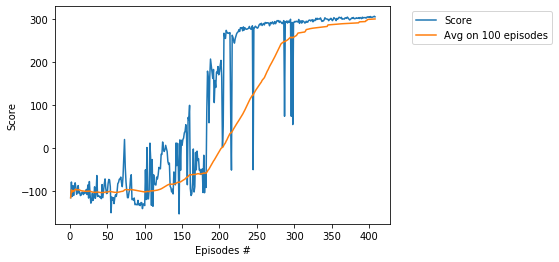

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 306.86,	Score: 306.86 	Time: 00:00:20
Episode 1	Average Score: 307.91,	Score: 308.96 	Time: 00:00:16
Episode 2	Average Score: 308.11,	Score: 308.51 	Time: 00:00:16
Episode 3	Average Score: 308.30,	Score: 308.85 	Time: 00:00:16
Episode 4	Average Score: 307.87,	Score: 306.15 	Time: 00:00:17
Episode 5	Average Score: 307.78,	Score: 307.35 	Time: 00:00:15


In [8]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 310.14,	Score: 310.14 	Time: 00:00:20
Episode 1	Average Score: 307.22,	Score: 304.31 	Time: 00:00:15
Episode 2	Average Score: 306.21,	Score: 304.20 	Time: 00:00:15
Episode 3	Average Score: 306.33,	Score: 306.67 	Time: 00:00:15
Episode 4	Average Score: 306.38,	Score: 306.60 	Time: 00:00:15
Episode 5	Average Score: 306.49,	Score: 307.04 	Time: 00:00:15


In [9]:
env.close()